In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import *
from utils import *
import timeit
from copy import deepcopy

In [2]:
xs = get_statespace(11)
print(xs.shape)

(121, 2)


In [3]:
npc = 3**2
nact = 4
sigma = 1.0
seed = 0
params = uniform_2D_pc_weights(npc, nact,sigma=sigma, seed=seed)


In [4]:
state = xs[0]
newstate = xs[1]
reward = 10
gamma = 0.9
beta = 1
onehotg = np.array([1,0,0,0])
aprob = np.array([0.6,0.2,0.1,0.1])

In [5]:
%timeit learn(deepcopy(params), reward, newstate,state, onehotg,aprob, gamma, etas=[1,1,1,1,1],balpha=0.0, noise=0.0, paramsindex=[], beta=1)

1.36 ms ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
%timeit learn_opt(deepcopy(params), reward, newstate,state, onehotg,aprob, gamma, etas=[1,1,1,1,1],balpha=0.0, noise=0.0, paramsindex=[], beta=1)

918 µs ± 127 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%timeit predict_batch_placecell(params, xs)

40.4 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
print(params[1][4])
params[1][4][0,1] += 0.1
print(params[1][4])
pcs = predict_batch_placecell(params, xs)
print(xs.shape, pcs.shape)
plt.imshow(pcs[:,4].reshape(51,51))

[[1. 0.]
 [0. 1.]]
[[1.  0.1]
 [0.  1. ]]
(121, 2) (121, 9)


ValueError: cannot reshape array of size 121 into shape (51,51)

[[ 0.1  0. ]
 [-0.1  0.1]]
(2601, 2) (2601, 9)


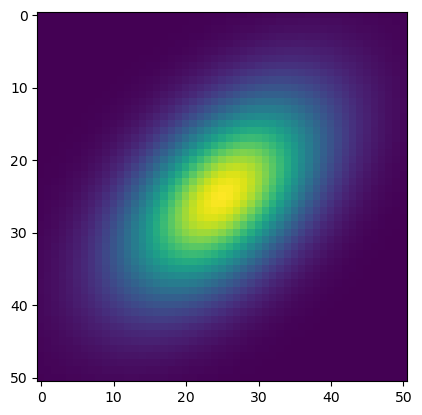

In [ ]:
params[1][4][0,1] = 0.0
params[1][4][1,0] = -0.1
print(params[1][4])
pcs = predict_batch_placecell(params, xs)
print(xs.shape, pcs.shape)
plt.imshow(pcs[:,4].reshape(51,51))

[[ 0.1   0.05]
 [-0.05  0.1 ]]
(2601, 2) (2601, 9)


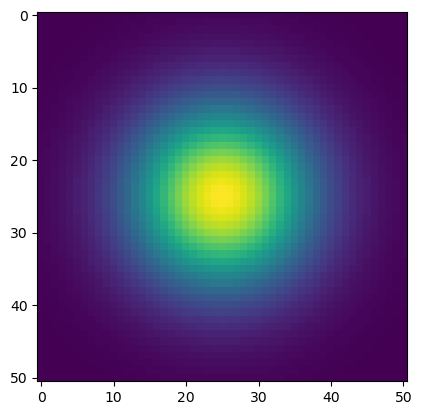

In [ ]:
params[1][4] = np.eye(2)*0.1
params[1][4][0,1] += 0.05

params[1][4][1,0] += -0.05
print(params[1][4])
pcs = predict_batch_placecell(params, xs)
print(xs.shape, pcs.shape)
plt.imshow(pcs[:,4].reshape(51,51))